In [ ]:
Autor: Maksim Lobanov
telegram:@cjetix

# Searching for Element Matches in Large Data Sets
For a large set of data represented by vectors, you need to find a match in a large sample. Those. sweep. It is necessary to analyze algorithms for speed and completeness.
The data in which you need to look for a match has 2 918 139 records,
The size of the marked data (there is a request vector and a response ID) - 100 000 records

Quality metric - aac@5 (the correct answer for the requested vector must be in the top 5 closest)

# Import

In [2]:
import gc
import random
from builtins import int

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pypl
import os
import sys

from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
import polars as pl
import sweetviz as sv
import gc
import math
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

#import hdbscan
from sklearn.cluster import KMeans
from datetime import datetime
import time
import faiss
from sklearn.model_selection import KFold

!{sys.executable} -m pip install ipython-autotime
%load_ext autotime

time: 346 µs (started: 2024-01-29 22:20:49 +04:00)


In [3]:
import os
print(os.__file__)

/home/max/miniconda3/envs/ml10/lib/python3.10/os.py
time: 471 µs (started: 2024-01-29 22:20:49 +04:00)


# Read Data

## Define Function

In [4]:
path_data = os.path.join('data','base.csv')
path_train = 'data/train.csv'
path_validation = 'data/validation.csv'
path_validation_ansers = 'data/validation_answer.csv'

time: 547 µs (started: 2024-01-29 22:20:51 +04:00)


In [5]:

df_base:pd.DataFrame = None# pl.read_csv(path_data)
df_train:pd.DataFrame = None #pl.read_csv(path_train)
df_train_id_target:pd.DataFrame = None # pl.DataFrame()
df_validation:pd.DataFrame = None
df_validation_answers:pd.DataFrame = None

mapping_baseid_ix = {}
mapping_ix_base_id = {}

def read_datasets():
    return read_datasets_pandas()

def read_datasets_pandas():
    global df_base
    global df_train
    global id_index
    global  mapping_baseid_ix
    global mapping_ix_base_id
    global df_train_id_target
    global df_validation
    global df_validation_answers

    path_data = os.path.join('data','base.csv')
    df_base = pl.read_csv(path_data).to_pandas()
    print('Shape base data = ', df_base.shape)

    path_train = 'data/train.csv'
    df_train = pl.read_csv(path_train).to_pandas()
    print('Shape train data = ', df_train.shape)

    id_index= df_base['Id']
    df_base.set_index('Id', inplace=True)
    mapping_baseid_ix = { id:indx for indx,id in enumerate(id_index) }
    mapping_ix_base_id = {v:k for k,v in mapping_baseid_ix.items()}

    df_train_id_target = df_train[['Id','Target']]
    df_train.drop(['Id','Target'], inplace=True,axis=1)
    
    df_validation = pl.read_csv(path_validation).to_pandas()
    df_validation.set_index('Id', inplace=True)

    df_validation_answers = pd.read_csv(path_validation_ansers)
    df_validation_answers.set_index('Id',inplace=True)
    df_validation_answers['target'] = df_validation_answers['Expected']
    print('shape validation data', df_validation.shape)
    print('Shape validation answers', df_validation_answers.shape)

    return df_base, df_train

def read_datasets_polars__():
    # polars lib wrong work on ubuntu system. skip using
    global df_base
    global df_train
    global id_index
    global  mapping_baseid_ix
    global mapping_ix_base_id
    global df_train_id_target

    path_data = os.path.join('data','base.csv')
    df_base = pl.read_csv(path_data)
    print('Shape base data = ', df_base.shape)

    path_train = 'data/train.csv'
    df_train = pl.read_csv(path_train)
    print('Shape train data = ', df_train.shape)
    id_index = df_base['Id']
    df_base.set_index('Id',inplace=True)
    mapping_baseid_ix = { id:indx for indx,id in enumerate(id_index) }
    mapping_ix_base_id = {v:k for k,v in mapping_baseid_ix.items()}

    df_train_id_target = df_train[['Id','Target']]
    _= df_train.drop_in_place('Id')
    _ = df_train.drop_in_place('Target')
    print( df_base.head(5) )
    return df_base, df_train



time: 1.67 ms (started: 2024-01-29 22:20:52 +04:00)


## Data Transform funcitons 

In [6]:
class StdScaling(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.std_scaller = StandardScaler()
        self.orig_columns = []
        return

    def fit(self, X:pd.DataFrame, y= None):
        print(X.shape)
        self.std_scaller.fit(X)
        self.orig_columns = X.columns
        return self

    def transform(self, X:pd.DataFrame, y=None):
        res = self.std_scaller.transform(X)
        #res = pl.from_numpy( res,schema=self.orig_columns, orient="row" )
        res = pd.DataFrame(data=res, columns=self.orig_columns, index=X.index)
        return res

scale_pipeline = Pipeline([
    ('Std Scalling', StdScaling())
])


time: 720 µs (started: 2024-01-29 22:20:53 +04:00)


In [7]:
g_row = None
g_max_diviaton = 1.9 # 2.3 -0.685

class CRowScallingCompressTransformation(TransformerMixin):
    def __init__(self, max_diviaton = 1.9):
        self.max_diviaton = max_diviaton
        return
    
    def fit(self,X):
        return self
    
    def transform(self,X):
        return 
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)
    
    def __scale_row(self, row_data:pd.Series)->pd.Series:
        row_data = np.array(row_data)
        for ix,val in enumerate(row_data):    
            if abs(val)<self.max_diviaton: continue
            new_abs = ( abs(val) - self.max_diviaton + 1)**0.3 - 1 +self.max_diviaton
            new_val = math.copysign(new_abs, val)
            row_data[ix] = new_val
        return tuple(row_data)

    def __scaleDfCompress(self, df_base_scaled:pd.DataFrame):
        batch_size = 100000
        mapp_df_store = []
        orig_columns = df_base_scaled.columns
        df_base_scaled = pl.from_pandas(df_base_scaled)
        for ix in tqdm(range(0, df_base_scaled.shape[0],batch_size)):
            df_sliced = df_base_scaled.slice(ix, batch_size)
            mapped = df_sliced.map_rows(lambda x: self.__scale_row(x))
            mapp_df_store.append(mapped)
    
        df_res:pd.DataFrame = pl.concat(mapp_df_store).to_pandas()
        df_res.columns = orig_columns
        del mapp_df_store
        gc.collect()
        return df_res


time: 838 µs (started: 2024-01-29 22:20:54 +04:00)


## Read data

In [8]:
def read_datasets_and_scale():
    global df_base_scalled
    global df_train_scalled 
    read_datasets()
    scale_pipeline.fit(df_base)
    df_base_scalled = scale_pipeline.transform(df_base)
    df_train_scalled = scale_pipeline.transform(df_train)
    return


time: 305 µs (started: 2024-01-29 22:20:55 +04:00)


In [9]:
read_datasets()
scale_pipeline.fit(df_base)
df_base_scalled:pd.DataFrame = scale_pipeline.transform(df_base)
df_train_scalled:pd.DataFrame = scale_pipeline.transform(df_train)
df_validation = scale_pipeline.transform(df_validation)
display(df_base_scalled.head(2))
display(df_train_scalled.head(2))
gc.collect();

Shape base data =  (2918139, 73)
Shape train data =  (100000, 74)
shape validation data (100000, 72)
Shape validation answers (100000, 2)
(2918139, 72)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.866975,1.274319,-0.024410,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,0.246358,...,1.254600,-0.991073,0.075152,-0.159574,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491


time: 13.7 s (started: 2024-01-29 22:20:56 +04:00)


## Make Profile Report

In [33]:
my_report = sv.analyze(df_base)
my_report.show_html('eda_report.thml')

                                             |          | [  0%]   00:00 -> (? left)

Report eda_report.thml was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
time: 7min 58s (started: 2024-01-29 16:38:12 +04:00)


In [34]:
print('Test data')
ix = 123
smpl_train = df_train_scalled.iloc[ix].to_numpy().reshape(-1)
print( df_train_id_target.iloc[ix] )
target_base_id = df_train_id_target.iloc[ix]['Target']
print('target base id = ', target_base_id)
ix_base = mapping_baseid_ix[target_base_id]
print('index in base = ', ix_base)
smpl_base = df_base_scalled.iloc[ix_base].to_numpy().reshape(-1)
gc.collect();

Test data
Id          123-query
Target    319003-base
Name: 123, dtype: object
target base id =  319003-base
index in base =  299436
time: 3.17 s (started: 2024-01-29 16:46:11 +04:00)


In [35]:
display( 'euclidean_distances',euclidean_distances([smpl_train,smpl_base]) )
display( 'cosine_distances',cosine_distances( [smpl_train,smpl_base] ))

'euclidean_distances'

array([[0.        , 1.82764025],
       [1.82764025, 0.        ]])

'cosine_distances'

array([[0.        , 0.03007589],
       [0.03007589, 0.        ]])

time: 47 ms (started: 2024-01-29 16:46:14 +04:00)


# Make Simle Baseline

In [10]:
def KFoldSplits():
    """    
    :return: yield x_train, y_train, x_test, y_test 
    """
    kf = KFold(n_splits=5, random_state=189, shuffle=True)
    for train_index, test_index in kf.split(list( df_train_id_target.index )):
        y_train = df_train_id_target.loc[train_index]['Target']
        y_test = df_train_id_target.loc[test_index]['Target']
        dt_test = df_train_scalled.loc[test_index]
        yield y_train, y_test, dt_test
    return
    


time: 498 µs (started: 2024-01-29 22:21:10 +04:00)


## Define scores functions

In [11]:
def custom_crossval_score(resolver_mnl:BaseEstimator):
    scores = []
    for y_train, y_test, dt_test in KFoldSplits():
        pred_kn = resolver_mnl.predict( dt_test )
        pred_kn = [i[0] for i in pred_kn]
        scores.append( score_acc5(y_test, pred_kn) )
    return (scores, np.mean(scores))

def score_acc_n(target_values, predicted_indexes, n,
                is_Errors_ix_return = False,
                mapping_ix_base_id = mapping_ix_base_id
                ):
    #assert type(df_train_id_target['Target'].values.tolist()[0] ) ==str, 'Wrong target_values arg shape, must be 1d array of strings'
    acc = 0
    erros = []

    for ix_raw, (target, ix_predicted) in enumerate( zip(target_values, predicted_indexes)):
        if type( ix_predicted[0]) is str:
            nb_base_ids = ix_predicted
        else:
            nb_base_ids = [ mapping_ix_base_id[ix] for ix in ix_predicted ][:n]

        acc += int( target in nb_base_ids)
        if is_Errors_ix_return:
            if target not in nb_base_ids: erros.append(ix_raw)
            #print(target[1],el,nb_base_ids)
        #break
        #acc += int(target in [base_index[r] for r in el])
    acc = acc/len(target_values)

    if is_Errors_ix_return:
        return (acc, erros)
    return acc

def score_acc5(target_values, predicted_indexes):
    return score_acc_n(target_values, predicted_indexes, n=5)


time: 1.63 ms (started: 2024-01-29 22:21:10 +04:00)


## Baseline  With Custom Approximate Nearest Neighbors (clustering and brute force search)
I cluster the data, to search, I will first find the nearest centroid, define the cluster and use brute force to find the top 5 closest elements  

In [11]:
class CCustromNNSearch(BaseEstimator):
    def __init__(self, num_clusters:int = 100, random_state = 23689):
        self.num_clusters = num_clusters
        self.clust_kmeans = None
        self.items_per_cluster = {}
        self.random_state = random_state
        return
    
    def fit(self,X):
        print('Start clustering')
        self.clust_kmeans = KMeans(n_clusters=self.num_clusters, random_state=self.random_state, n_init="auto").fit(X)
        print('End clustering')
        
        base_clusters = self.clust_kmeans.predict(df_base_scalled)
        self.df_base_clusters = pd.DataFrame(data = base_clusters, columns=['cluster'], index=df_base_scalled.index)
        
        self.items_per_cluster = {}
        self.nn_map_per_cluster = {}
        for clust_number in tqdm( range(self.num_clusters) ):
            ix_4_cluster = self.df_base_clusters.query(f'cluster=={clust_number}')
            self.items_per_cluster[clust_number] = X.loc[ix_4_cluster.index]
            self.nn_map_per_cluster[clust_number] =  NearestNeighbors(n_neighbors=5, radius=1)
            self.nn_map_per_cluster[clust_number].fit(self.items_per_cluster[clust_number].values)

        centroids  =  self.clust_kmeans.cluster_centers_
        self.nn_4_clusters_centroids = NearestNeighbors(n_neighbors=1, radius=1)
        self.nn_4_clusters_centroids.fit(centroids)
        print('End fit')
        return self
    
    def predict(self, X:np.array):
        assert len(X.shape)==2, 'Shape argument must be 2'
        res = []
        for i in tqdm( range(X.shape[0]) ):
            pred_item = self.predict_per_item(X[i])
            res.append(pred_item)
        return res
    
    def predict_per_item(self, x_item):
        clust_id =  self.nn_4_clusters_centroids.kneighbors([x_item], 1, return_distance=False)[0][0]
        ix_in = self.nn_map_per_cluster[clust_id].kneighbors([x_item],5,return_distance=False)[0]
        tmp_df = self.items_per_cluster[clust_id]
        res = list( tmp_df.iloc[ix_in].index )
        return res

nns = CCustromNNSearch(num_clusters = 50)
nns.fit(df_base_scalled)
print('test search knn',nns.predict( np.array([df_train_scalled.iloc[0]]) ))    

Start clustering
End clustering


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


End fit


100%|██████████| 1/1 [00:00<00:00, 45.84it/s]

test search knn [['675816-base', '877519-base', '361564-base', '2725256-base', '13406-base']]
time: 1min 33s (started: 2024-01-29 20:08:01 +04:00)


In [39]:
preds = nns.predict( df_train_scalled.values )

100%|██████████| 100000/100000 [11:33<00:00, 144.10it/s]


time: 11min 34s (started: 2024-01-29 16:51:27 +04:00)


In [37]:
print( score_acc5(df_train_id_target['Target'], preds) )

0.55741



time to fit algo - 97 sec
time match all items - 694 sec (144 it/s)



# Work With  NMSLIB


!!! Attentions
This part of the project requires the nmslib library
I was able to install on Ubuntu and for Python version 10 (for 11, 12 it was not possible to install)

you can skip execution

In [12]:
import nmslib

time: 60.5 ms (started: 2024-01-29 22:21:30 +04:00)


In [13]:
class BaseLine_NMSLIB(BaseEstimator):
    """
     - mnslib manual - https://raw.githubusercontent.com/nmslib/nmslib/master/manual/latex/manual.pdf
     
    -  Explanation for the M parameter in CreateIndex in nmslib #366 
                         https://github.com/allenai/scispacy/issues/366
    """
    def __init__(self, M=15, efC=100, threadqty = 6, space = 'l2', print_progress = True):

        self.index_time_params = {'M': M,
                                  'indexThreadQty': threadqty,
                                  'efConstruction': efC
                                  }
        self.M = M
        self.efC = efC
        self.space = space
        self.index = nmslib.init(method='hnsw', space=space)
        self.print_progress = print_progress
        self.threadqty = threadqty
        return

    def fit(self, data):
        self.index.addDataPointBatch(data)
        self.index.createIndex( self.index_time_params, print_progress=self.print_progress)
        return self

    def predict(self, data, k=5):
        nbrs = self.index.knnQueryBatch(data, k = k, num_threads = self.threadqty)
        return nbrs

time: 751 µs (started: 2024-01-29 22:21:38 +04:00)


In [14]:

resolver_mnl = BaseLine_NMSLIB()
resolver_mnl.fit( df_base_scalled )



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


BaseLine_NMSLIB()

time: 3min 17s (started: 2024-01-29 22:21:39 +04:00)


## try tune huper parameters

In [ ]:
search_socrs = []
for m_val in [7,10,15,20,25,30,35]:
    print('Test for M=', m_val)
    resolver_mnl = BaseLine_NMSLIB(M=m_val)
    resolver_mnl.fit(df_base_scalled)
    search_socrs.append((f'M = {m_val}', custom_crossval_score(resolver_mnl) ))
    print('Scores = ', search_socrs[-1])


In [ ]:
search_socrs = []
for m_val in [40,50,60]:
    print('Test for M=', m_val)
    resolver_mnl = BaseLine_NMSLIB(M=m_val)
    resolver_mnl.fit(df_base_scalled)
    search_socrs.append((f'M = {m_val}', custom_crossval_score(resolver_mnl) ))
    print('Scores = ', search_socrs[-1])


In [ ]:
search_socrs = []
for m_val in [35]:
    print('Test for M=', m_val)
    resolver_mnl = BaseLine_NMSLIB(M=m_val)
    resolver_mnl.fit(df_base_scalled)
    search_socrs.append((f'M = {m_val}', custom_crossval_score(resolver_mnl) ))
    print('Scores = ', search_socrs[-1])


Optimal value for using M=35 (speed\memory usage\score )

## work with optimal parameters

In [15]:
M_val_4_use = 25
resolver_mnl = BaseLine_NMSLIB(M=M_val_4_use)
resolver_mnl.fit(df_base_scalled)



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


BaseLine_NMSLIB(M=25)

time: 3min 54s (started: 2024-01-29 22:26:11 +04:00)


In [16]:
pred_kn = resolver_mnl.predict(df_train_scalled)
pred_kn = [i[0] for i in pred_kn]
print( score_acc5(df_train_id_target['Target'], pred_kn) )
pred_kn = resolver_mnl.predict(df_train_scalled,k=10)
pred_kn = [i[0] for i in pred_kn]
print( score_acc_n(df_train_id_target['Target'], pred_kn,n=10) )


0.51567
0.5456
time: 8.17 s (started: 2024-01-29 22:30:40 +04:00)


In [17]:
_,error_ix = score_acc_n(df_train_id_target['Target'], pred_kn,n=5,is_Errors_ix_return=True ) 

time: 2.22 s (started: 2024-01-29 22:31:10 +04:00)


Let's try to find trash features
Let's calculate the difference between the query vector and the target, and so on for the entire dataset.

I will calculate the difference module.

Using the resulting dataset, I calculate the median across the columns.

stand boxblot for display


In [18]:
    
err_distances = []
truth_dist = []
error_ix = set(error_ix)

sub_distances_err = []
sub_distances_truth = []

for ix in tqdm( df_train_id_target.index ):
    target_base_id = df_train_id_target.iloc[ix]['Target']

    itm_base = df_base_scalled.iloc[ mapping_baseid_ix[target_base_id] ]
    itm_train = df_train_scalled.iloc[ix]
    dist_equlid = euclidean_distances([itm_base,itm_train])[1,0] 
    if ix in error_ix:
        err_distances.append( dist_equlid )
        sub_distances_err.append( np.abs( itm_base - itm_train ) )
    else:
        truth_dist.append(dist_equlid)
        sub_distances_truth.append( np.abs( itm_base - itm_train ) )
        

100%|██████████| 100000/100000 [00:28<00:00, 3464.97it/s]

time: 28.9 s (started: 2024-01-29 22:31:12 +04:00)


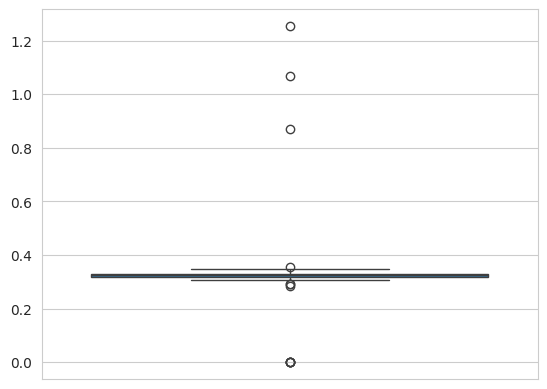

time: 421 ms (started: 2024-01-29 22:31:52 +04:00)


In [19]:
median_err_4all = np.array(np.median( sub_distances_err, axis=0 ))
sns.boxplot(data = median_err_4all).set_title('features noise');



In [20]:
ft_4_drop = [str(i) for i in np.where( median_err_4all>0.5 ) [0]]
print('features 4 drop', ft_4_drop)

features 4 drop ['33', '59', '65']


In [21]:
df_train_scalled.drop( ft_4_drop, axis=1, inplace=True )
df_base_scalled.drop( ft_4_drop, axis=1, inplace=True  )

In [17]:
M_val_4_use = 25
resolver_mnl = BaseLine_NMSLIB(M=M_val_4_use)
resolver_mnl.fit(df_base_scalled)



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


BaseLine_NMSLIB(M=25)

## Train with optimal parameters and drop useles features

In [20]:
M_val_4_use = 25
ft_4_drop = ['33', '59', '65']
df_train_scalled.drop( ft_4_drop, axis=1, inplace=True )
df_base_scalled.drop( ft_4_drop, axis=1, inplace=True  )
resolver_mnl = BaseLine_NMSLIB(M=M_val_4_use)
resolver_mnl.fit(df_base_scalled)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


BaseLine_NMSLIB(M=25)

time: 3min 29s (started: 2024-01-29 22:42:39 +04:00)


In [21]:
pred_kn = resolver_mnl.predict(df_train_scalled)
pred_kn = [i[0] for i in pred_kn]

scores ,error_ix = score_acc_n(df_train_id_target['Target'], pred_kn,n=5,is_Errors_ix_return=True )
print('count errros = ', len(error_ix))
print('Scores', scores)

count errros =  45048
Scores 0.54952
time: 3.14 s (started: 2024-01-29 22:46:08 +04:00)


In [22]:
gc.collect()

151

time: 310 ms (started: 2024-01-29 22:46:11 +04:00)


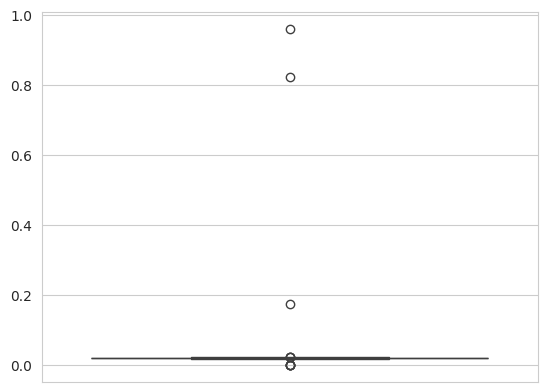

time: 320 ms (started: 2024-01-29 22:46:12 +04:00)


In [23]:
sns.boxplot(data = np.median( sub_distances_truth, axis=0 ));

In [24]:
np.median( sub_distances_err, axis=0 )

array([0.33633682, 0.3213406 , 0.32931213, 0.32321916, 0.3253071 ,
       0.32418397, 0.        , 0.33280546, 0.32540194, 0.32118033,
       0.30574303, 0.3277426 , 0.32841082, 0.3307202 , 0.32020716,
       0.2938152 , 0.31862718, 0.33589987, 0.33628994, 0.32632808,
       0.31003818, 0.        , 0.31499911, 0.35381892, 0.33551737,
       0.        , 0.32911179, 0.33105701, 0.31505103, 0.31393768,
       0.32076394, 0.31803231, 0.33549383, 1.25444794, 0.31629476,
       0.29300388, 0.32055065, 0.32213066, 0.33000642, 0.32627861,
       0.31912214, 0.32850372, 0.31686423, 0.33362135, 0.        ,
       0.31938334, 0.33553476, 0.33567427, 0.33473796, 0.31463284,
       0.31681877, 0.34700528, 0.32556981, 0.32513947, 0.32579047,
       0.32489758, 0.31698309, 0.31643622, 0.32087431, 1.06838538,
       0.33019588, 0.32141606, 0.32479777, 0.28618639, 0.32533018,
       0.87070618, 0.3263434 , 0.31348572, 0.31074878, 0.32701729,
       0.        , 0.31212335])

time: 203 ms (started: 2024-01-29 22:46:12 +04:00)


In [25]:
np.median( sub_distances_truth, axis=0 )

array([0.02337562, 0.02037637, 0.0210181 , 0.02055501, 0.02222854,
       0.01993716, 0.        , 0.01970459, 0.02020891, 0.01884354,
       0.01944786, 0.01905587, 0.02128183, 0.02008906, 0.02029339,
       0.02094079, 0.01929104, 0.0204519 , 0.0211388 , 0.01988276,
       0.01849914, 0.        , 0.0191858 , 0.02214088, 0.02060717,
       0.        , 0.01952226, 0.02004069, 0.01931673, 0.0201893 ,
       0.02205119, 0.02001129, 0.02219916, 0.82325153, 0.02020627,
       0.02078862, 0.01896961, 0.02006548, 0.02017558, 0.02081457,
       0.02045212, 0.02055594, 0.02037996, 0.02042554, 0.        ,
       0.01887401, 0.02008614, 0.02109678, 0.0216146 , 0.01913117,
       0.0203326 , 0.02468484, 0.01894899, 0.01843613, 0.01948261,
       0.01941022, 0.01983815, 0.01893297, 0.0192794 , 0.96074687,
       0.02040512, 0.02336384, 0.02101252, 0.01865978, 0.02057445,
       0.17359513, 0.01980415, 0.02003497, 0.01893765, 0.01967511,
       0.        , 0.01926137])

time: 205 ms (started: 2024-01-29 22:46:12 +04:00)


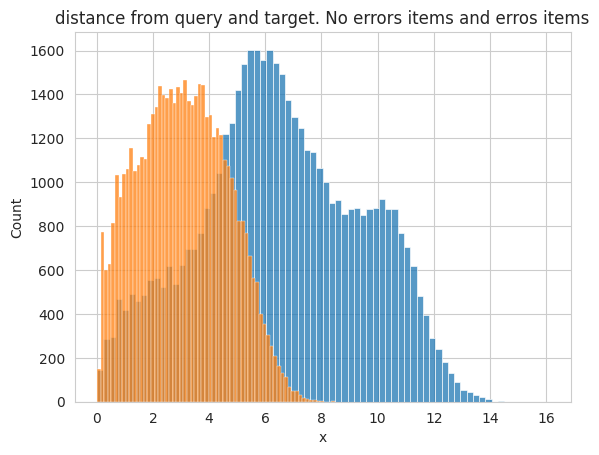

time: 381 ms (started: 2024-01-29 22:47:43 +04:00)


In [28]:

sns.histplot(data=pd.DataFrame(data = err_distances, columns=['x']) , x="x").set_title('distance from query and target. No errors items and erros items');
sns.histplot(data=pd.DataFrame(data = truth_dist, columns=['x']) , x="x");

The histogram shows that the distance between the request and the correct answer is much greater for the wrong ones than for the correct ones. Apparently there are noisy signs that add distance.

# Faiss using 
- avaliable indexes https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

In [12]:

class CMahalnobis_transform(TransformerMixin):
    def __int__(self):
        self.cov = None
        #self.L = None
        self.mahalanobis_transform = None
        return

    def fit(self, X):
        self.cov = np.dot(X.T, X) / X.shape[0]
        L = np.linalg.cholesky(self.cov)
        self.mahalanobis_transform = np.linalg.inv(L)
        return self

    def transform(self, X):
        res = np.dot(X, self.mahalanobis_transform.T)
        return res

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)



time: 0 ns (started: 2024-01-29 20:10:52 +04:00)


In [67]:
# In the NMSLIB section I made a selection of trash features.
def drop_uselese_features(ft_4_drop = ['33', '59', '65']):
    global df_base_scalled
    global df_train_scalled
    global df_validation
    df_train_scalled.drop( ft_4_drop, axis=1, inplace=True,errors ='ignore')
    df_base_scalled.drop( ft_4_drop, axis=1, inplace=True ,errors ='ignore' )
    df_validation.drop(ft_4_drop, axis=1, inplace=True ,errors ='ignore' )
    return

time: 0 ns (started: 2024-01-29 21:47:02 +04:00)


## Brute force search


In [68]:
def make_brute_force_searh(df_base_m:pd.DataFrame,df_train_m:pd.DataFrame, df_train_target:pd.DataFrame ):
    dimension = df_base_m.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(df_base_m)

    k = 5  # number of nearest neighbors to retrieve
    distances, pred_indexes = index.search(df_train_m, k)
    print('Score = ', score_acc5(df_train_target['Target'], pred_indexes))
    return 

time: 0 ns (started: 2024-01-29 21:47:07 +04:00)


In [15]:
make_brute_force_searh(df_base_scalled, df_train_scalled, df_train_id_target)

Score =  0.65838
time: 3min 32s (started: 2024-01-29 20:11:35 +04:00)


Execution time - 3 min 17 sec. (197 seconds)
Scores =  0.65838

The library uses all CPU cores, so it works faster than Python releases, even with a custom search approximation algorithm. 
I can use this time as a guide when exploring other algorithms.

try drop useless features 

In [69]:
drop_uselese_features()

time: 547 ms (started: 2024-01-29 21:47:17 +04:00)


In [17]:
make_brute_force_searh(df_base_scalled, df_train_scalled, df_train_id_target)

Score =  0.69689
time: 3min 36s (started: 2024-01-29 20:15:38 +04:00)


score grow to 0.697 from 0.65838

try use Mahalanobis distance

In [18]:
cm_transform = CMahalnobis_transform()
df_base_m = cm_transform.fit_transform(df_base_scalled)
df_train_m = cm_transform.transform(df_train_scalled)

time: 2.47 s (started: 2024-01-29 20:21:11 +04:00)


In [19]:
make_brute_force_searh(df_base_m, df_train_m, df_train_id_target)

Score =  0.69655
time: 3min 29s (started: 2024-01-29 20:21:19 +04:00)


result is zero - the result is zero - there is no point in using the Mahalanobis distance

I'll try to use another thing - do a compressive transformation of features if they exceed a certain threshold

In [70]:
g_row = None
g_max_diviaton = 1.9 # 2.3 -0.685

class CRowScallingCompressTransformation(TransformerMixin):
    def __init__(self, max_diviaton = 1.9):
        self.max_diviaton = max_diviaton
        return

    def fit(self,X):
        return self

    def transform(self,X):
        return self.__scaleDfCompress(X)

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def __scale_row(self, row_data:pd.Series)->pd.Series:
        row_data = np.array(row_data)
        for ix,val in enumerate(row_data):
            if abs(val)<self.max_diviaton: continue
            new_abs = ( abs(val) - self.max_diviaton + 1)**0.3 - 1 +self.max_diviaton
            new_val = math.copysign(new_abs, val)
            row_data[ix] = new_val
        return tuple(row_data)

    def __scaleDfCompress(self, df_base_scaled:pd.DataFrame):
        batch_size = 100000
        mapp_df_store = []
        index_orig = df_base_scalled.index
        orig_columns = df_base_scaled.columns
        df_base_scaled = pl.from_pandas(df_base_scaled)
        for ix in tqdm(range(0, df_base_scaled.shape[0],batch_size)):
            df_sliced = df_base_scaled.slice(ix, batch_size)
            mapped = df_sliced.map_rows(lambda x: self.__scale_row(x))
            mapp_df_store.append(mapped)

        df_res:pd.DataFrame = pl.concat(mapp_df_store).to_pandas()
        df_res.columns = orig_columns
        del mapp_df_store
        gc.collect()
        return df_res

comp_transform = CRowScallingCompressTransformation()
df_base_scalled_cmp = comp_transform.transform(df_base_scalled)
df_train_scalled_cmp = comp_transform.transform(df_train_scalled)
df_validation_cmp = comp_transform.transform(df_validation)



100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

time: 1min 24s (started: 2024-01-29 21:49:08 +04:00)


In [71]:
df_base_scalled_cmp['id'] = df_base_scalled.index
df_base_scalled_cmp.set_index('id',inplace=True)


time: 31 ms (started: 2024-01-29 21:51:36 +04:00)


In [27]:
make_brute_force_searh(df_base_scalled_cmp, df_train_scalled_cmp, df_train_id_target)

Score =  0.70069
time: 3min 15s (started: 2024-01-29 20:37:08 +04:00)


new score value - 0.70069
I will use a new dataset with transformation

In [72]:
df_base_scalled = df_base_scalled_cmp
df_train_scalled = df_train_scalled_cmp

df_validation_cmp['id'] = df_validation.index
df_validation_cmp.set_index('id', inplace=True)
df_validation = df_validation_cmp

time: 172 ms (started: 2024-01-29 21:51:41 +04:00)


In [74]:
assert df_base_scalled.shape[1] == df_train_scalled.shape[1],'Error - data shape not equals'
assert df_base_scalled.shape[1] == df_validation.shape[1],'Error - data shape not equals'

time: 0 ns (started: 2024-01-29 21:52:53 +04:00)


## work with LSH 

In [75]:
class faiss_LSH(BaseEstimator):
    def __init__(self, nbits = 64):
        self.nbits = nbits
        return

    def fit(self, X:pd.DataFrame, y= None):
        self.lsh_index = faiss.IndexLSH(X.shape[1], self.nbits)
        self.lsh_index.train(X)
        self.lsh_index.add(X)
        return self

    def predict(self, X:pd.DataFrame, y=None, k=5):
        res = self.lsh_index.search( X,k )
        return res


time: 0 ns (started: 2024-01-29 18:39:34 +04:00)


In [76]:
scores = []
for n_bits in tqdm( [8,10,16,20,24,32,48,64] ):
    lsh_1 = faiss_LSH(n_bits)
    lsh_1.fit(df_base_scalled)
    time_start = time.time()
    distances, pred_indexes = lsh_1.predict(df_train_scalled)
    scores.append((n_bits, score_acc5(df_train_id_target['Target'], pred_indexes), time.time() - time_start))

100%|██████████| 8/8 [13:41<00:00, 102.71s/it]

time: 13min 41s (started: 2024-01-29 18:39:35 +04:00)


In [77]:
for nbits, sc, dtime in scores:
    print('Hash size', nbits, 'score-', sc, 'time predict (sec)', dtime)

Hash size 8 score- 0.00067 time predict (sec) 90.52421402931213
Hash size 10 score- 0.00297 time predict (sec) 111.76885509490967
Hash size 16 score- 0.10536 time predict (sec) 108.858633518219
Hash size 20 score- 0.28569 time predict (sec) 132.03090357780457
Hash size 24 score- 0.33953 time predict (sec) 129.36000180244446
Hash size 32 score- 0.42484 time predict (sec) 30.9359769821167
Hash size 48 score- 0.51457 time predict (sec) 170.42289900779724
Hash size 64 score- 0.57368 time predict (sec) 34.39170503616333
time: 0 ns (started: 2024-01-29 18:53:22 +04:00)


LS implementation from the Faiss library is not very suitable for use with this dataset
compromise speed-search completeness is poor, completeness is low at relatively slow speed - 
   score- 0.507,  time predict (sec) 31.417027950286865 ( 16% from bruteforce algo )

## Work with HNSW
the algorithm is the same as in NSMLIB
use large M value

In [78]:
d = df_base_scalled.shape[1]  # vector size
M = 128
index = faiss.IndexHNSWFlat(d, M)
print(index.hnsw)

<faiss.swigfaiss.HNSW; proxy of <Swig Object of type 'faiss::HNSW *' at 0x0000026886B8D180> >
time: 47 ms (started: 2024-01-29 18:53:52 +04:00)


In [79]:
index.add(df_base_scalled)

time: 4min 7s (started: 2024-01-29 18:54:07 +04:00)


In [80]:
distances, pred_indexes = index.search(df_train_scalled, k = 5)

time: 3.72 s (started: 2024-01-29 18:59:18 +04:00)


In [81]:
score_acc5(df_train_id_target['Target'], pred_indexes)

0.64504

time: 578 ms (started: 2024-01-29 18:59:36 +04:00)


time for creating index - 247 sec.
memory usage - 4.4 GB
search performace - 3.72 sec (26881 it/sec)
score - 0.64504

## Work with IndexFlatL2

In [32]:
class CFaiss_indexIVF():
    def __init__(self, num_clusters = 500, nprobe_clusters = 1):
        self.num_clusters = num_clusters
        self.nprobe_clusters = nprobe_clusters
        self.index = None
        return
    
    def fit(self, X):
        dimension = X.shape[1]  # the dimension of the vectors
        quantizer = faiss.IndexFlatL2(dimension)  # coarse quantizer
        self.index = faiss.IndexIVFFlat(quantizer, dimension, self.num_clusters)
        self.index.train(X)
        self.index.add(X)
        self.index.nprobe = self.nprobe_clusters        
        return self
    
    def setNProbeClusters(self, nprobe:int):
        self.nprobe_clusters = nprobe
        return 
    
    def predict(self, X, k=5, is_return_dist = False):
        distances, indx = self.index.search(X, k)
        if is_return_dist:
            return distances, indx
        return indx

class CFaiss_indexIVF_IP():
    def __init__(self, num_clusters = 500, nprobe_clusters = 1):
        self.num_clusters = num_clusters
        self.nprobe_clusters = nprobe_clusters
        self.index = None
        return

    def fit(self, X):
        dimension = X.shape[1]  # the dimension of the vectors
        quantizer = faiss.IndexFlatIP(dimension)  # coarse quantizer
        self.index = faiss.IndexIVFFlat(quantizer, dimension, self.num_clusters)
        self.index.train(X)
        self.index.add(X)
        self.index.nprobe = self.nprobe_clusters
        return self

    def setNProbeClusters(self, nprobe:int):
        self.nprobe_clusters = nprobe
        return

    def predict(self, X, k=5, is_return_dist = False):
        distances, indx = self.index.search(X, k)
        if is_return_dist:
            return distances, indx
        return indx
    

def makeFaiss_IndexIVF(df:pd.DataFrame, num_clusters = 500, nprobe_clusters = 1):
    dimension = df.shape[1]  # the dimension of the vectors
    print("dim = ", dimension)
    quantizer = faiss.IndexFlatL2(dimension)  # coarse quantizer
    index = faiss.IndexIVFFlat(quantizer, dimension, num_clusters)
    index.train(df)
    print(index.is_trained)  # True
    print(index.ntotal)   # 0
    index.add(df)
    index.nprobe = nprobe_clusters
    print(index.ntotal)   # 1000000
    return index


time: 0 ns (started: 2024-01-29 20:59:05 +04:00)


In [83]:
dimension = df_base_scalled.shape[1]  # the dimension of the vectors
print("dim = ", dimension)
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid
quantizer = faiss.IndexFlatL2(dimension)  # coarse quantizer
d = dimension
k=500

index = faiss.IndexIVFFlat(quantizer, dimension, k)
index.train(df_base_scalled)
print(index.is_trained)  # True
print(index.ntotal)   # 0
index.add(df_base_scalled)
print(index.ntotal)   # 1000000
#nlist = 20
#define the inverted index 
# index = faiss.IndexIVFPQ(quantizer,  d, nlist, m, bits)

dim =  69
True
0
2918139
time: 5.92 s (started: 2024-01-29 19:03:32 +04:00)


In [98]:
for num_clust in [50,100,500,1000]:
    nprobe = num_clust // 200
    if nprobe ==0: nprobe = 1
    index = CFaiss_indexIVF(num_clusters=num_clust, nprobe_clusters=nprobe)
    index.fit(df_base_scalled)
    index.nprobe = 1
    time_start = time.time()
    pred_indexes = index.predict(df_train_scalled, 5)
    t_end =  time.time()
    print(f'number clusters = {num_clust}, nprobe={nprobe}, score=',score_acc5(df_train_id_target['Target'], pred_indexes),'time predict=',t_end - time_start)

number clusters = 50, nprobe=1, score= 0.61514 time predict= 57.32038640975952
number clusters = 100, nprobe=1, score= 0.60732 time predict= 29.308367013931274
number clusters = 500, nprobe=2, score= 0.64661 time predict= 12.668601512908936
number clusters = 1000, nprobe=5, score= 0.67074 time predict= 15.232285499572754
time: 2min 19s (started: 2024-01-29 19:32:23 +04:00)


When using IndexIVFFlat, it is important to find a balance between the number of clusters, the parameter (nprob, which is responsible for how many nearby clusters will be processed), and the speed of requests.
The algorithm does not use large amounts of memory.
    works relatively quickly on learning and prediction
     score= 0.64661 time predict= 12.668601512908936 (7898 it/sec)
     score= 0.67074 time predict= 15.232285499572754 (6565 it/sec)


## work with IndexFlatIP
this algorthis algorithm uses cosine distancethis algorithm uses cosine distanceithm uses cosine distance

CFaiss_indexIVF_IP

In [101]:
for num_clust in [50,100,500,1000]:
    nprobe = num_clust // 200
    if nprobe ==0: nprobe = 1
    index = CFaiss_indexIVF_IP(num_clusters=num_clust, nprobe_clusters=nprobe)
    index.fit(df_base_scalled)
    time_start = time.time()
    pred_indexes = index.predict(df_train_scalled, 5)
    t_end =  time.time()
    print(f'number clusters = {num_clust}, nprobe={nprobe}, score=',score_acc5(df_train_id_target['Target'], pred_indexes),'time predict=',t_end - time_start)

number clusters = 50, nprobe=1, score= 0.60685 time predict= 49.075889110565186
number clusters = 100, nprobe=1, score= 0.61427 time predict= 28.597602605819702
number clusters = 500, nprobe=2, score= 0.64677 time predict= 20.60328221321106
number clusters = 1000, nprobe=5, score= 0.67113 time predict= 21.0862455368042
time: 2min 18s (started: 2024-01-29 19:42:38 +04:00)


The results are close to indexIVF. Almost identical

## Predict validatin set

for validation I will use IndexIVFFlat, with parameters
num_clusters=1000, nprobe_clusters=5
as an optimal option

In [77]:
index = CFaiss_indexIVF(num_clusters=1000, nprobe_clusters=5)
index.fit(df_base_scalled)
pred_indexes = index.predict(df_train_scalled, 5)
print(f'score=',score_acc5(df_train_id_target['Target'], pred_indexes))

score= 0.67074
time: 22.5 s (started: 2024-01-29 22:03:23 +04:00)


In [78]:
pred_indexes = index.predict(df_validation, 5)

time: 14.4 s (started: 2024-01-29 22:04:07 +04:00)


In [79]:
print(f'score=',score_acc5(df_validation_answers['target'], pred_indexes))

score= 0.66844
time: 531 ms (started: 2024-01-29 22:04:57 +04:00)


on validation data set score =  0.66844

# Work With Earroneous Predictions

clustering algorithm memory usage
https://i.stack.imgur.com/Yl4tV.png
https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html


## clustering train dataset

In [33]:
findx = CFaiss_indexIVF(num_clusters=1000, nprobe_clusters = 10)
findx.fit(df_base_scalled)
pred_indexes = findx.predict(df_train_scalled)
score_acc5(df_train_id_target['Target'], pred_indexes)

0.68388

time: 36.5 s (started: 2024-01-29 20:59:08 +04:00)


In [34]:
kmeans = KMeans(n_clusters=100, random_state=2323, n_init="auto").fit(df_train_scalled)
clust_kmeans = kmeans.predict(df_train_scalled)

time: 4.5 s (started: 2024-01-29 20:59:45 +04:00)


In [35]:
acc, ix_errors = score_acc_n(df_train_id_target['Target'], pred_indexes, n=5, is_Errors_ix_return= True)
print('score', acc)
ix_errors = set(ix_errors)

score 0.68388
time: 453 ms (started: 2024-01-29 20:59:49 +04:00)


Let's look at clusters and the number of errors in them

In [36]:
df_target_with_errs = df_train_id_target[df_train_id_target.columns].copy()
df_target_with_errs['is_error'] = 0
df_target_with_errs['cluster'] = clust_kmeans
for ix in df_target_with_errs.index:
    if ix not in ix_errors: continue
    df_target_with_errs.loc[ix,'is_error'] = 1

time: 1.39 s (started: 2024-01-29 20:59:50 +04:00)


In [39]:
pv_err_in_clusters = df_target_with_errs.pivot_table(index=['cluster'],values=['is_error'], aggfunc='sum')/df_target_with_errs.pivot_table(index=['cluster'],values=['is_error'], aggfunc='count')
pv_err_in_clusters['count'] = df_target_with_errs.pivot_table(index=['cluster'],values=['is_error'], aggfunc='count')
pv_err_in_clusters
display(pv_err_in_clusters)

,is_error,count
cluster,,
0,0.342105,342
1,0.175648,1930
2,0.235857,1255
3,0.221945,1604
4,0.311594,1242
...,...,...
95,0.366497,985
96,0.326087,736
97,0.297683,561


time: 16 ms (started: 2024-01-29 21:08:17 +04:00)


In [40]:
pv_err_in_clusters.sort_values(by='is_error', ascending=False)[:10]

,is_error,count
cluster,,
10,0.853150,1968
88,0.687135,342
65,0.647619,840
80,0.584627,1288
58,0.571429,455
76,0.546939,245
54,0.541667,936
29,0.534913,802
42,0.495385,325


time: 0 ns (started: 2024-01-29 21:08:18 +04:00)


There are several clusters that have a lot of errors ( 85% top ). Let's try to figure something out.

In [41]:
clust_id = int( pv_err_in_clusters.reset_index().sort_values(by='is_error', ascending=False).iloc[0]['cluster'] )
print('work with clauster id = ', clust_id)
df_id_4_cluster = df_target_with_errs.query(f'cluster == {clust_id}')
df_base_4_cluster = df_base_scalled.loc[df_id_4_cluster['Target']]
df_train_4_cluster = df_train_scalled.loc[df_id_4_cluster.index]

work with clauster id =  10
time: 750 ms (started: 2024-01-29 21:08:20 +04:00)


In [42]:
findx = CFaiss_indexIVF(num_clusters=1000, nprobe_clusters = 10)
findx.fit(df_base_scalled)
dis,pred_indexes = findx.predict(df_train_4_cluster, is_return_dist=True)
score_acc5(df_id_4_cluster['Target'], pred_indexes)

0.14684959349593496

time: 10.5 s (started: 2024-01-29 21:08:23 +04:00)


let's try to remove features that make a greater contribution to the distance

In [44]:
df_sub_features =  pd.DataFrame(data = np.mean( np.abs( df_base_4_cluster.values - df_train_4_cluster.values  ), axis=0 ), columns=['abs'] )
df_sub_features = df_sub_features.sort_values(by='abs',ascending=False)
display(df_sub_features[:10])

,abs
44,0.976656
53,0.946968
62,0.940561
51,0.900913
56,0.895514
8,0.892654
24,0.890475
5,0.889020
60,0.878214
40,0.867910


time: 15 ms (started: 2024-01-29 21:09:23 +04:00)


<Axes: xlabel='abs'>

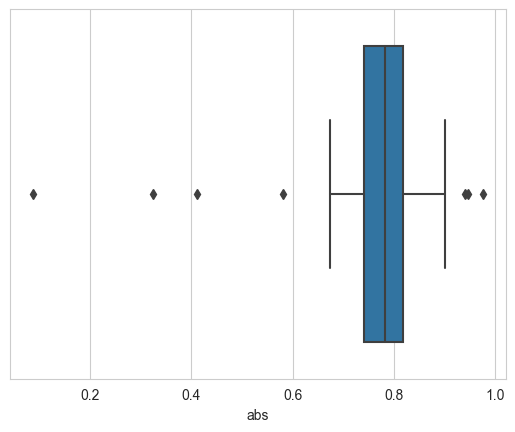

time: 156 ms (started: 2024-01-29 21:09:27 +04:00)


In [45]:
sns.boxplot(x=df_sub_features["abs"])

In [190]:
def filter_columns_4_drop(columns, index_ft_4drop):
    index_ft_4drop = set(index_ft_4drop)
    res = [colname for ix, colname in enumerate(columns) if ix not in index_ft_4drop]
    return res
        

time: 0 ns (started: 2024-01-28 02:26:28 +04:00)


In [196]:
df_sub_features

,abs
44,1.009284
62,0.962398
53,0.961404
8,0.922505
51,0.919091
...,...
61,0.683342
6,0.588400
43,0.414956
21,0.334703


time: 16 ms (started: 2024-01-28 02:28:56 +04:00)


Let’s remove the features and evaluate how much better the samples from the cluster merge


In [234]:
colls_new = filter_columns_4_drop(df_base_4_cluster.columns, list(df_sub_features[:5].index) )
print(len(colls_new),colls_new)

64 ['0', '1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '46', '47', '48', '49', '50', '51', '53', '55', '56', '57', '58', '60', '61', '62', '63', '66', '67', '68', '69', '70', '71']
time: 0 ns (started: 2024-01-28 12:28:04 +04:00)


In [235]:
findx = CFaiss_indexIVF_IP(num_clusters=1000, nprobe_clusters = 20)
findx.fit(df_base_scalled[colls_new])
pred_indexes = findx.predict(df_train_4_cluster[colls_new])
score_acc5(df_id_4_cluster['Target'], pred_indexes)

0.14713216957605985

time: 8.3 s (started: 2024-01-28 12:28:05 +04:00)


I experimented a little - I couldn’t add much quality. max 1-2% for this cluster

In [47]:
def make_smpl_from_base():
    return df_base_scalled.sample( frac =0.01,random_state=34)

time: 0 ns (started: 2024-01-29 21:12:10 +04:00)


In [48]:

smpl_cont = int( len( df_base_scalled )/40/3/1000 )
print('smpl count = ', smpl_cont)
df4tsne = make_smpl_from_base()

#hdb = hdbscan.HDBSCAN (min_cluster_size=smpl_cont)

#hdb.fit( df4tsne )

smpl count =  24
time: 157 ms (started: 2024-01-29 21:12:11 +04:00)


In [49]:
tsne = TSNE(n_components=2, random_state=737)
#hdb = hdbscan.HDBSCAN (min_cluster_size=smpl_cont)
print('shape tsne dataframe = ', df4tsne.shape)
X_tsne = tsne.fit_transform(df4tsne)
df_tsne = pd.DataFrame( X_tsne, columns=['x','y'] )


shape tsne dataframe =  (29181, 69)
time: 2min 25s (started: 2024-01-29 21:12:12 +04:00)


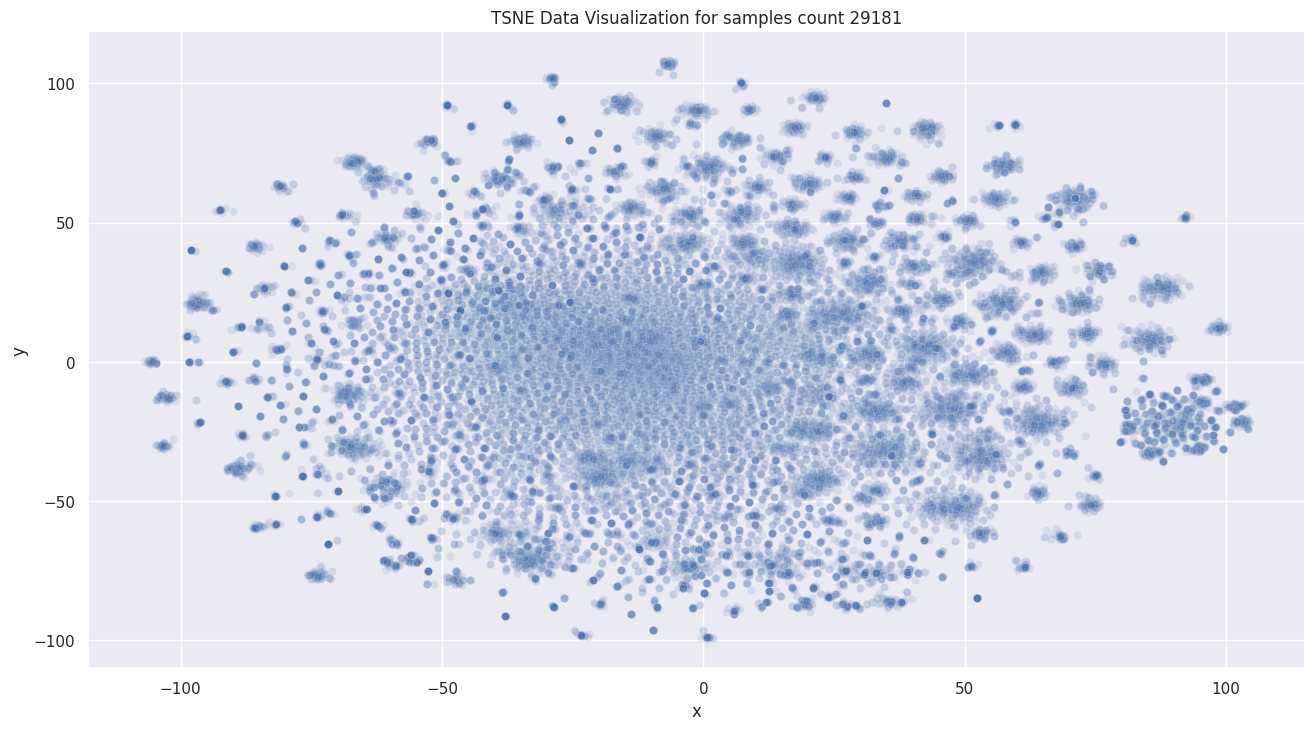

In [25]:
%matplotlib inline

sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.scatterplot(data = df_tsne, x='x',y='y',alpha=.13).set(title="TSNE Data Visualization for samples count " +str(df4tsne.shape[0]));


In [28]:

kmeans = KMeans(n_clusters=30, random_state=2323, n_init="auto").fit(df4tsne)
clust_kmeans = kmeans.predict(df4tsne)

In [29]:
pd.Series(data=clust_kmeans).value_counts()

19    2528
1     1995
0     1732
14    1462
21    1322
13    1250
4     1190
15    1168
12    1055
2     1055
22    1052
29     993
16     992
5      965
25     947
7      925
24     863
17     849
6      823
23     818
8      790
10     779
11     761
9      625
3      578
28     507
26     472
27     322
20     218
18     145
Name: count, dtype: int64

In [30]:
df_tsne['clust_kmeans'] = clust_kmeans
df_tsne['clust_kmeans'] =df_tsne['clust_kmeans'].apply(lambda x: str(x)) 

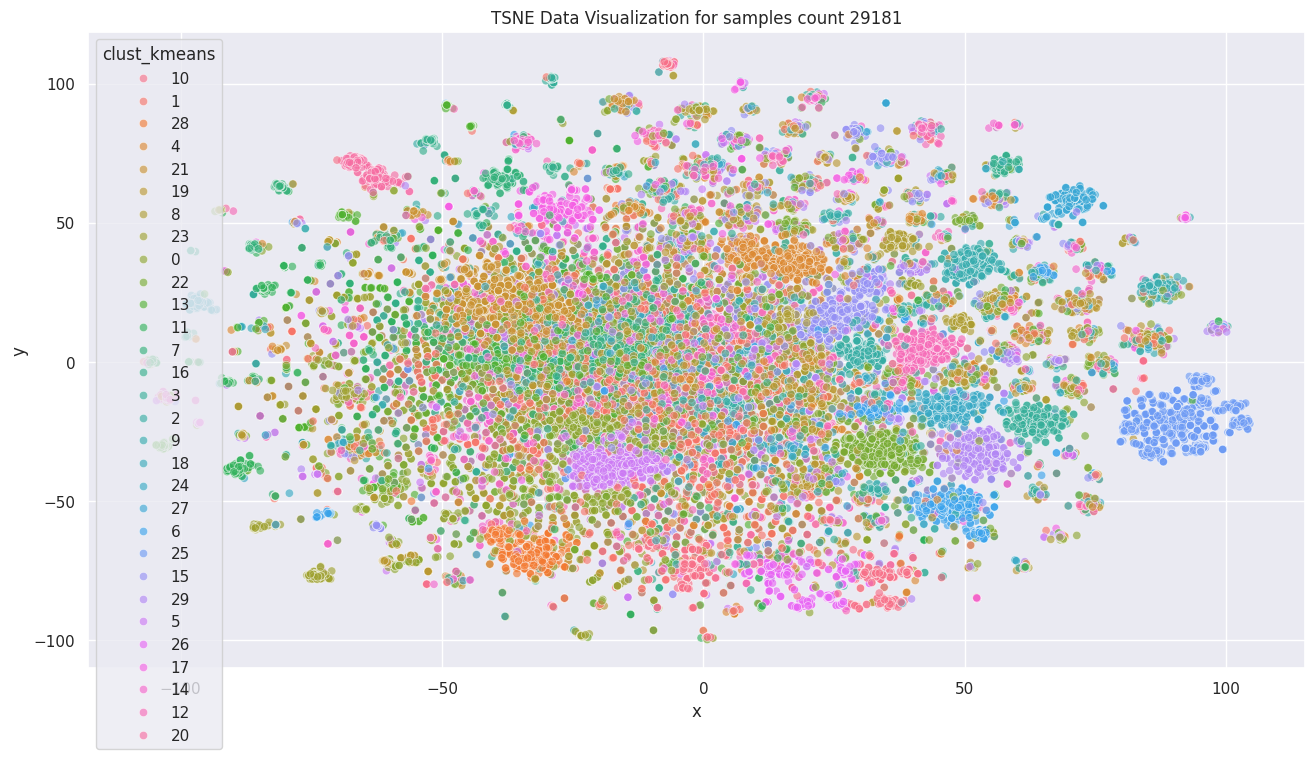

In [31]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

# df_tsne['clust_kmeans'] = df_tsne['clust_kmeans'].to_string()

pal = sns.color_palette("hls",len(df_tsne['clust_kmeans'].unique()))

sns.scatterplot(data = df_tsne, x='x',y='y', hue='clust_kmeans',alpha=.63).set(title="TSNE Data Visualization for samples count and clusters" +str(df_tsne.shape[0]));


# Summary
When using algorithms, you need to make compromises - search completeness, search performance, amount of resources.

Thus, the NNSW algorithm has the best performance, but requires a lot of resources. The completeness of the search is not ideal (85-90%). Requires a lot of memory. The algorithm is implemented in several libraries - the NMSLIV implementation works faster, but is not stable, the speed is higher on the CPU. 
Fais can run on GPU (I can’t test it)

The LSH implementation of Faiss for this dataset did not work - it was too slow.

IndexIVFFlat and IndexFlatIP showed approximately the same results - a compromise in speed and completeness and memory size.

For validation I will use IndexIVFFlat, with parameters
num_clusters=1000, nprobe_clusters=5
as an optimal option
    - on validation data set score =  0.66844 (time - 14 sec)
    - on test score= 0.67074